In [20]:
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
dfjointe = pd.read_csv('Bases de données/donnéesjointes.csv')
dfjointe.drop('Unnamed: 0', axis=1, inplace=True)

path = 'Bases de données/revenus.csv'
dfrev = pd.read_csv(path, sep = ';')
rename = {'CodePostal' : 'Code postal', ' Niveau de vie Commune ':'Niveau de vie commune', ' NiveaudevieDépartement ':'Niveau de vie département', 'Departement' : 'Département'}
dfrev = dfrev.rename(rename, axis= 1)

#On garde les colonnes qui nous intéresse
dfrev.drop(['Code postal', 'Niveau de vie département'], axis=1, inplace=True)
dfrev.set_index('Nom Commune', inplace=True)
dfjointe = dfjointe.join(dfrev, on='Localisation', how='left')
dfjointe.reset_index(inplace=True)
dfjointe.drop_duplicates(subset='index', inplace=True)
dfjointe.set_index('index', inplace=True)

In [22]:
dfjointe

,Prix (€),Marque,Taille,Etat,Matière,Localisation,Option de paiement,Vues,Date d'ajout,Département,Libellé du département,Nbvoix,%popent,%popvot,Niveau de vie commune
index,,,,,,,,,,,,,,,
0,6.0,NaN,W34 | FR 44,Très bon état,NaN,Tourny,Carte bancaire,13,"12/28/2023, 6:19:17 PM",27.0,Eure,53761.0,12.39,25.92,21 250
1,5.0,Zara,W32 | FR 42,Satisfaisant,NaN,Riantec,Carte bancaire,2,"12/29/2023, 10:43:33 AM",56.0,Morbihan,82148.0,13.44,26.09,20 710
2,6.0,Zara,W30 | FR 40,Très bon état,NaN,Feignies,Carte bancaire,1,"12/29/2023, 11:39:14 AM",59.0,Nord,232470.0,12.77,29.29,16 860
3,5.0,Leeyo Jeans,W28 | FR 38,Très bon état,NaN,Buigny-Saint-Maclou,Carte bancaire,0,"12/29/2023, 12:51:07 PM",80.0,Somme,52514.0,12.78,26.61,21 846
4,5.0,Casual by Gémo,W38 | FR 48,Neuf sans étiquette,NaN,Fougueyrolles,Carte bancaire,1,"12/29/2023, 11:09:58 AM",24.0,Dordogne,43986.0,13.77,25.77,18 238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,5.0,H&M,W23 | FR 32,Très bon état,NaN,Paris,Carte bancaire,12,"12/27/2023, 12:27:55 PM",75.0,Paris,298944.0,21.94,40.16,NaN
1392,9.0,AARHON,W30 | FR 40,Neuf sans étiquette,NaN,Esternay,Carte bancaire,5,"12/29/2023, 1:50:51 PM",51.0,Marne,37475.0,9.80,21.94,18 285
1393,5.0,SMOG,W36 | FR 46,Bon état,NaN,Le Mans,Carte bancaire,6,"12/28/2023, 8:43:05 PM",72.0,Sarthe,46201.0,11.21,25.23,19 113


In [62]:
#Pas de prise en compte des marques car non exhaustif, de la matière car trop peu de données,
#d'option de paiement car tjrs carte bleue, pas le département car déja décrit par le revenu
#et les votes
dfmodel = pd.DataFrame()
dfmodel = dfjointe[['Prix (€)', 'Taille', 'Etat', 'Vues', '%popvot', 'Niveau de vie commune']]
dfmodel = dfmodel.dropna()

dfmodel['Niveau de vie commune'] = dfmodel['Niveau de vie commune'].apply(lambda x: x.replace(' ',''))
dfmodel['Niveau de vie commune'] = pd.to_numeric(dfmodel['Niveau de vie commune'])
dfmodel['Vues'] = pd.to_numeric(dfmodel['Vues'])

#transformation des variables catégorielles, jean de base est S et bon état
dummiesEtat = pd.get_dummies(dfmodel['Etat'], drop_first=True, dtype=int)
dummiesTaille = pd.get_dummies(dfmodel['Taille'], drop_first=False, dtype=int)
dummiesTaille.drop('S', axis=1, inplace=True)
dfmodel.drop(['Taille', 'Etat'], axis=1, inplace=True)
dfmodeldummies = pd.concat([dfmodel, dummiesTaille, dummiesEtat], axis=1)

In [63]:
dummiesTaille.describe()

,5XL,L,M,W23 | FR 32,W24 | FR 34,W25 | FR 34,W26 | FR 36,W27 | FR 36,W28 | FR 38,W29 | FR 38,...,W31 | FR 40,W32 | FR 42,W33 | FR 42,W34 | FR 44,W36 | FR 46,W38 | FR 48,W40 | FR 50,W48 | FR 58,XL,XXS / 32 / 4
count,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,...,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000,1263.000000
mean,0.007918,0.016627,0.044339,0.047506,0.015835,0.010293,0.084719,0.026920,0.055424,0.021378,...,0.080760,0.168646,0.080760,0.068884,0.063341,0.040380,0.015835,0.007918,0.003959,0.001584
std,0.088663,0.127920,0.205928,0.212803,0.124888,0.100971,0.278573,0.161914,0.228896,0.144697,...,0.272574,0.374587,0.272574,0.253356,0.243672,0.196927,0.124888,0.088663,0.062819,0.039778
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
dfmodeldummies['Prix (€)'].value_counts()

Prix (€)
5.00     861
6.00     155
8.00      78
10.00     61
7.00      38
9.00      31
12.00     25
5.95       5
15.00      3
7.50       2
5.50       2
8.99       2
Name: count, dtype: int64

In [65]:
dfmodeldummies.columns

Index(['Prix (€)', 'Vues', '%popvot', 'Niveau de vie commune', '5XL', 'L', 'M',
       'W23 | FR 32', 'W24 | FR 34', 'W25 | FR 34', 'W26 | FR 36',
       'W27 | FR 36', 'W28 | FR 38', 'W29 | FR 38', 'W30 | FR 40',
       'W31 | FR 40', 'W32 | FR 42', 'W33 | FR 42', 'W34 | FR 44',
       'W36 | FR 46', 'W38 | FR 48', 'W40 | FR 50', 'W48 | FR 58', 'XL',
       'XXS / 32 / 4', 'Neuf avec étiquette', 'Neuf sans étiquette',
       'Satisfaisant', 'Très bon état'],
      dtype='object')

In [73]:
#Pas de stratification par les communes possibles car trop peu de sorties de prix
X_train, X_test, Y_train, Y_test = train_test_split(dfmodeldummies[['Vues', '%popvot', 'Niveau de vie commune',
                                                                    'L', 'M', '5XL',
                                                                    'W23 | FR 32',
                                                                    'W24 | FR 34',
                                                                    'W25 | FR 34',
                                                                    'W26 | FR 36',
                                                                    'W27 | FR 36',
                                                                    'W28 | FR 38',
                                                                    'W29 | FR 38',
                                                                    'W30 | FR 40',
                                                                    'W31 | FR 40',
                                                                    'W32 | FR 42',
                                                                    'W33 | FR 42',
                                                                    'W34 | FR 44',
                                                                    'W36 | FR 46',
                                                                    'W38 | FR 48',
                                                                    'W40 | FR 50',
                                                                    'W48 | FR 58',
                                                                    'XL',
                                                                    'XXS / 32 / 4',
                                                                    'Neuf avec étiquette',
                                                                    'Neuf sans étiquette',
                                                                    'Satisfaisant',
                                                                    'Très bon état'
                                                                   ]],
                                                    dfmodeldummies['Prix (€)'],
                                                    train_size=0.75,
                                                   )

In [74]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

normalizer = preprocessing.Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [75]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

In [76]:
#calcul du R²
reg.score(X_test, Y_test)

0.23276370421264037

<Axes: title={'center': 'Coefficients de la première régression linéaire'}>

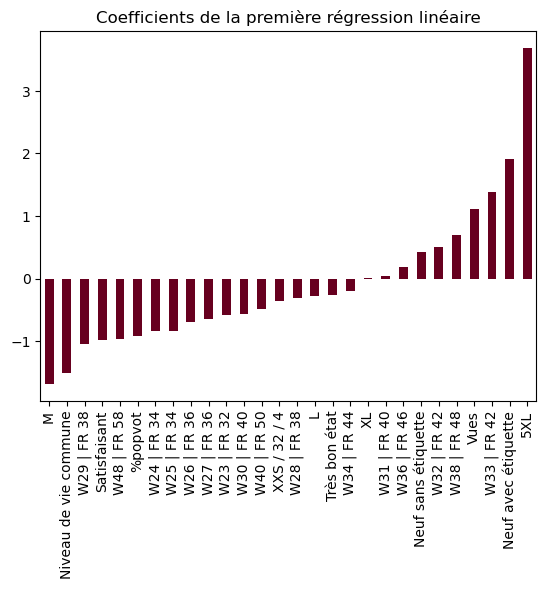

In [72]:
coeffs = pd.DataFrame(index=dfmodeldummies.drop('Prix (€)', axis=1).columns)
coeffs['Coefficients']=reg.coef_
coeffs.sort_values('Coefficients').sort_values('Coefficients').plot(kind='bar',
                                         colormap='RdBu',
                                        fontsize=10,
                                        title='Coefficients de la première régression linéaire',
                                        legend=False)

In [77]:
#Pas de stratification par les communes possibles car trop peu de sorties de prix
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(dfmodeldummies[['Vues', '%popvot', 'Niveau de vie commune',
                                                                    'Neuf avec étiquette',
                                                                    'Neuf sans étiquette',
                                                                    'Satisfaisant',
                                                                    'Très bon état'
                                                                   ]],
                                                    dfmodeldummies['Prix (€)'],
                                                    train_size=0.75,
                                                   )

In [86]:
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

normalizer = preprocessing.Normalizer()
X_train2 = normalizer.fit_transform(X_train2)
X_test2 = normalizer.transform(X_test2)

In [87]:
reg2 = LinearRegression()
reg2.fit(X_train2, Y_train2)

LinearRegression()

In [88]:
reg2.score(X_test2, Y_test2)

0.06770865093524359

In [83]:
coeffs2 = pd.DataFrame(index=dfmodeldummies.drop(['Prix (€)', 'L', 'M', '5XL',
                                                                    'W23 | FR 32',
                                                                    'W24 | FR 34',
                                                                    'W25 | FR 34',
                                                                    'W26 | FR 36',
                                                                    'W27 | FR 36',
                                                                    'W28 | FR 38',
                                                                    'W29 | FR 38',
                                                                    'W30 | FR 40',
                                                                    'W31 | FR 40',
                                                                    'W32 | FR 42',
                                                                    'W33 | FR 42',
                                                                    'W34 | FR 44',
                                                                    'W36 | FR 46',
                                                                    'W38 | FR 48',
                                                                    'W40 | FR 50',
                                                                    'W48 | FR 58',
                                                                    'XL',
                                                                    'XXS / 32 / 4'], axis=1).columns)

In [84]:
coeffs2['Coefficients']=reg2.coef_
coeffs2.sort_values('Coefficients').transpose()

,Satisfaisant,Niveau de vie commune,%popvot,Neuf sans étiquette,Très bon état,Vues,Neuf avec étiquette
Coefficients,-1.040216,-0.884293,-0.197933,-0.160332,-0.056032,0.915764,1.421422


<Axes: title={'center': 'Coefficients de la déuxième régression linéaire'}>

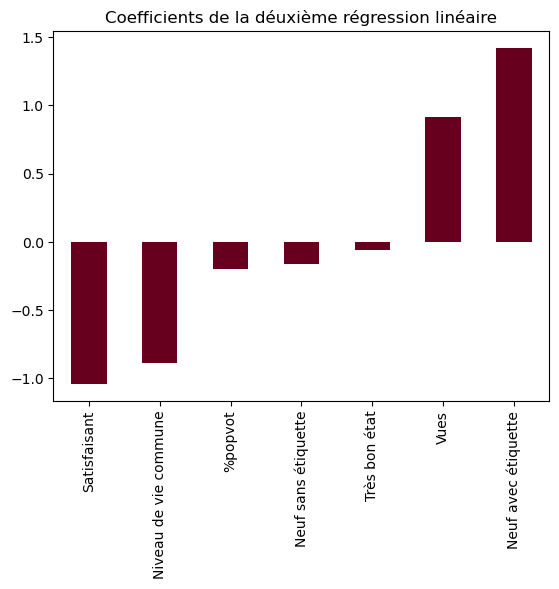

In [85]:
coeffs2.sort_values('Coefficients').plot(kind='bar',
                                         colormap='RdBu',
                                        fontsize=10,
                                        title='Coefficients de la déuxième régression linéaire',
                                        legend=False)